In [1]:
from Parser import parse_frames
from scipy.signal import medfilt, argrelextrema, argrelmin
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt

# Need a folder with npy compressed files of videos


Starting...
Keypoints from folder: output_points_bicep_correct2
Detected arm: left
[170.00216374]
Number of maxima points: 1
[54.49657773 55.47503239]
Number of reps performed: 2


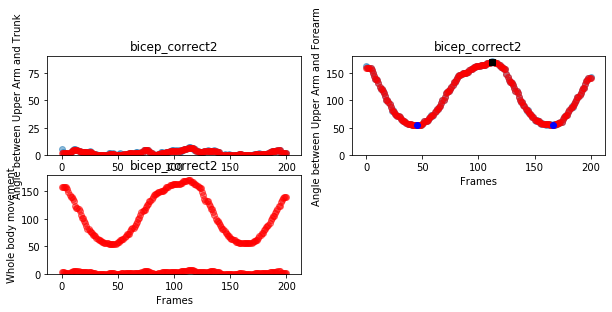

Angles between upper arm and trunk
Max angle: 7.4972220972903445
Min angle: 0.08778541923566362


Angles between upper arm and forearm
Max angle: 170.64132874890032
Min angle: 54.24463323110033


Starting...
Keypoints from folder: output_points_bicep_correct3
Detected arm: right
[]
Number of maxima points: 0
[50.30731823]
Number of reps performed: 1


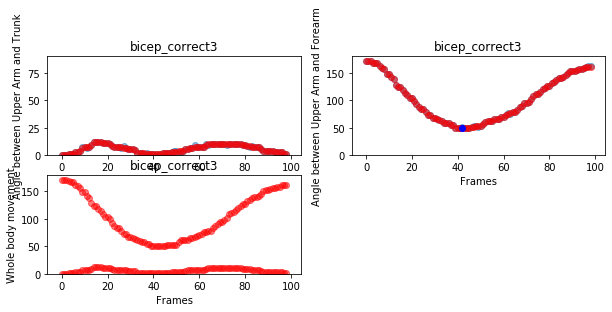

Angles between upper arm and trunk
Max angle: 11.970577781550958
Min angle: 0.10820696782098245


Angles between upper arm and forearm
Max angle: 170.75594018741262
Min angle: 48.95150669691576


Starting...
Keypoints from folder: output_points_bicep_side
Detected arm: right
[161.9326201  171.88592817]
Number of maxima points: 2
[36.28063958 32.93822519 33.34361794]
Number of reps performed: 3


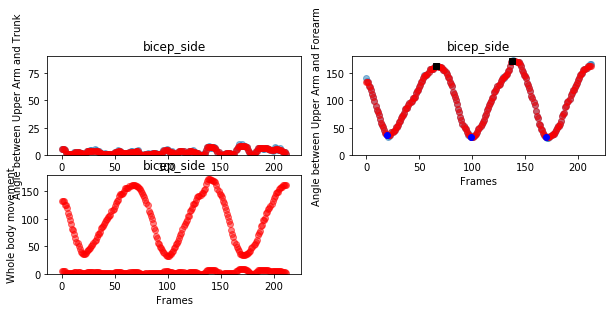

Angles between upper arm and trunk
Max angle: 9.997987857873243
Min angle: 0.0017980164883706796


Angles between upper arm and forearm
Max angle: 172.79989535066863
Min angle: 31.71870423751246


Starting...
Keypoints from folder: output_points_bicep_side5
Detected arm: right
[162.3797081  172.11784873 165.09188447 167.41264557]
Number of maxima points: 4
[36.23944807 33.75312856 33.20550001 35.89553792 33.45846204]
Number of reps performed: 5


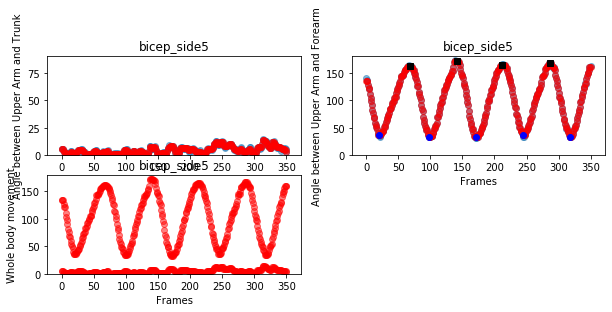

Angles between upper arm and trunk
Max angle: 14.719420138527669
Min angle: 0.00515994411044914


Angles between upper arm and forearm
Max angle: 172.72608189074154
Min angle: 31.68866926211813




In [39]:
# modify this path for other videos 
# input_folder = "/home/aleko/Documents/Projects/IndividualProject/bicepvid"
input_folder = "C:\\Users\\ak5u16\\Desktop\\IProject\\openpose"
folder_paths = glob.glob(os.path.join(input_folder, 'output_points_bicep*'))

# Return unit vector
def unit_vector(vect):
    return vect / np.linalg.norm(vect)

# Calcute angle between vectors
def calc_angle(vect1, vect2):
    unit_vect1 = unit_vector(vect1)
    unit_vect2 = unit_vector(vect2)
    return math.degrees(np.arccos(np.clip(np.dot(unit_vect1, unit_vect2), -1.0, 1.0)))

# Detecting sides (left or right) on videos  
# can use this method for other exercises
def detect_side(frame_poses):
    side = ''
    rside_joints = [pose.joint_keypoints['RSHOULDER'] + pose.joint_keypoints['RELBOW'] + pose.joint_keypoints['RWRIST'] for pose in frame_poses 
                    if pose.joint_keypoints['RSHOULDER'][2]!=0 and pose.joint_keypoints['RELBOW'][2]!=0 and pose.joint_keypoints['RWRIST'][2]!=0]
    
    lside_joints = [pose.joint_keypoints['LSHOULDER'] + pose.joint_keypoints['LELBOW'] + pose.joint_keypoints['LWRIST'] for pose in frame_poses 
                    if pose.joint_keypoints['LSHOULDER'][2]!=0 and pose.joint_keypoints['LELBOW'][2]!=0 and pose.joint_keypoints['LWRIST'][2]!=0]
    
    # think about the case when they are equal
    if len(rside_joints) > len(lside_joints): 
        side = 'right'
    else: 
        side = 'left'
    
    return side
    

# Method used for finding local minima points for repetition counting
# https://github.com/scipy/scipy/blob/master/scipy/signal/_peak_finding.py
def _boolrelextrema(data, comparator, axis=0, order=1, mode='clip'):
    if((int(order) != order) or (order < 1)):
        raise ValueError('Order must be an int >= 1')

    datalen = data.shape[axis]
    locs = np.arange(0, datalen)
    data = np.ma.masked_array(data, mask=np.hstack(([1], np.diff(data)))==0)
    if np.ma.is_masked(data):
        locs = locs[np.ma.getmask(data)==False]
        main = data.take(locs, axis=axis, mode=mode)
        results = np.zeros(data.shape, dtype=bool)
        for index, result in enumerate(_boolrelextrema(main, comparator, axis=axis, order=order, mode=mode)):
            results[locs[index]] = result
        return results
    else:
        locs = locs[np.ma.getmask(data)==False]
        results = np.ones(data.shape, dtype=bool)
        main = data.take(locs, axis=axis, mode=mode)
        for shift in range(1, order + 1):
            plus = data.take(locs + shift, axis=axis, mode=mode)
            minus = data.take(locs - shift, axis=axis, mode=mode)
            results &= comparator(main, plus)
            results &= comparator(main, minus)
            if(~results.any()):
                return results
        return results



for folder in folder_paths:
    video_name = os.path.basename(folder).replace('output_points_', '')
    frame_poses = parse_frames(folder)
                        
    # Computing angles
    trunk_vects = []
    upArm_forearm_angles = [] 
    upArm_trunk_angles = []
    upArm_vects = []
    forearm_vects = []
    upArm_vects = []
    forearm_vects = []
    
    # Detect side
    side = detect_side(frame_poses)
    print('Detected arm: ' + side)

    for posture in frame_poses:
        if side == 'right':
            parts = [posture.joint_keypoints['RSHOULDER'], posture.joint_keypoints['RELBOW'], posture.joint_keypoints['RWRIST']]
        else: 
            parts = [posture.joint_keypoints['LSHOULDER'], posture.joint_keypoints['LELBOW'], posture.joint_keypoints['LWRIST']]

        # upper arm 
        # [0]- x; [1] - y, [2] - c
        upArm_vect = [parts[0][0] - parts[1][0], parts[0][1] - parts[1][1]]
        upArm_vects.append(upArm_vect)
                 
        # trunk
        trunk_vect = [posture.joint_keypoints['NECK'][0] - posture.joint_keypoints['MIDHIP'][0], posture.joint_keypoints['NECK'][1] - posture.joint_keypoints['MIDHIP'][1]]
        trunk_vects.append(trunk_vect)
        # Calculate upper arm and trunk angle
        # convert to unit vectors
        upArm_vect = unit_vector(upArm_vect)
        trunk_vect = unit_vector(trunk_vect)

        # Calculate angle and add to list
        upArm_trunk_angles.append(calc_angle(upArm_vect, trunk_vect))

        # forearm
        forearm_vect = [parts[2][0] - parts[1][0], parts[2][1] - parts[1][1]]
        forearm_vects.append(forearm_vect)
        # Calculate upper arm and forearm angle 
        forearm_vect = unit_vector(forearm_vect)
        upArm_forearm_angles.append(calc_angle(upArm_vect, forearm_vect))


    # for now use medfilt
    # might use Kalman filter or something later instead
    upArm_vects = np.array(upArm_vects)
    trunk_vects = np.array(trunk_vects)
    upArm_trunk_angles = np.array(upArm_trunk_angles)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles, 5)
    upArm_trunk_angles_filtered = medfilt(upArm_trunk_angles_filtered, 5)
    upArm_forearm_angles = np.array(upArm_forearm_angles)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)
    upArm_forearm_angles_filtered = medfilt(upArm_forearm_angles, 5)
    
    # Count repetitions
    maxima = _boolrelextrema(upArm_forearm_angles_filtered, np.greater, order=1)
    indexesm = np.nonzero(maxima)[0]
    maxima_points = np.take(upArm_forearm_angles_filtered, indexesm)
    print(maxima_points)
    print("Number of maxima points: " + str(np.nonzero(maxima)[0].size))

    
    minima = _boolrelextrema(upArm_forearm_angles_filtered, np.less, order=1)
    indexes = np.nonzero(minima)[0]
    minima_points = np.take(upArm_forearm_angles_filtered, indexes)
    print(minima_points)
    print("Number of reps performed: " + str(np.nonzero(minima)[0].size))

    # Plot
    plt.figure(figsize=(10,4))

    ax1 = plt.subplot(311)
    plt.scatter(np.arange(upArm_trunk_angles.shape[0]), upArm_trunk_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Trunk')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,90) 

    plt.subplot(222)
    plt.scatter(np.arange(upArm_forearm_angles.shape[0]), upArm_forearm_angles, alpha=0.5)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Angle between Upper Arm and Forearm')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,180) 
  

    # Annotate minim apoints on the graph       
    plt.plot(indexes, upArm_forearm_angles_filtered[indexes], 'bo')
    plt.plot(indexesm, upArm_forearm_angles_filtered[indexesm], 'ks')
    
    
    plt.subplot(223)
    plt.scatter(np.arange(upArm_forearm_angles_filtered.shape[0]), upArm_forearm_angles_filtered, c='r', alpha=0.5)
    plt.scatter(np.arange(upArm_trunk_angles_filtered.shape[0]), upArm_trunk_angles_filtered, c='r', alpha=0.5)
    plt.title(video_name)
    plt.xlabel('Frames')
    plt.ylabel('Whole body movement')
    # Set range on y-axis so the plots are consistent
    plt.ylim(0,180) 
    plt.show()
        


    print("Angles between upper arm and trunk\nMax angle: " + str(np.max(upArm_trunk_angles)) + "\nMin angle: " + str(np.min(upArm_trunk_angles)))
    print('\n')
    print("Angles between upper arm and forearm\nMax angle: " + str(np.max(upArm_forearm_angles)) + "\nMin angle: " + str(np.min(upArm_forearm_angles)))
    print('\n' + '='*120 + '\n')